In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df = pd.read_csv('Fraud_Data.csv', parse_dates = ['signup_time', 'purchase_time'])
ip = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
ip['lower_bound_ip_address'] = ip.lower_bound_ip_address.astype(int)
ip['upper_bound_ip_address'] = ip.upper_bound_ip_address.astype(int)

In [4]:
df['ip_address'] = df.ip_address.astype(int)

In [5]:
df['class'].value_counts()/len(df['class'])

0    0.906354
1    0.093646
Name: class, dtype: float64

In [6]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,-2147483648,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,-2147483648,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0


In [7]:
df['delta'] = (df.purchase_time - df.signup_time)
df['delta'] = df.delta/np.timedelta64(1, 's')

In [8]:
df['Heure'] = df['purchase_time'].dt.hour

In [9]:
df['Jour'] = df['purchase_time'].dt.weekday

In [10]:
df['Mois'] = df['purchase_time'].dt.month

ip_data=df.iloc[:,9]

k=[]
for i in range(len(ip_data)):
    ip1=ip_data[i]
    tmp=ip[(ip['lower_bound_ip_address']<=ip1) & (ip['upper_bound_ip_address']>=ip1)]['country'].tolist()
k.extend(tmp if tmp else 'NULL')


In [11]:
def ipp(x):
    try :
        return ip[(ip['lower_bound_ip_address']<=x) & (ip['upper_bound_ip_address']>= x)]['country'].array[0]
    except:
        return np.nan
    

In [12]:
%time df['pays'] = df['ip_address'].apply(ipp)

Wall time: 11min 33s


In [13]:
fraud_pc = pd.DataFrame((df[df['class']==1].groupby(['pays'])['class'].count()/df.groupby(['pays'])['class'].count())*100)

In [14]:
fraud_pc = fraud_pc[~fraud_pc['class'].isna()]
fraud_pc = pd.concat([fraud_pc,pd.DataFrame(df.groupby(['pays'])['class'].count())],axis = 1)
fraud_pc.columns = ['fraud','obs']

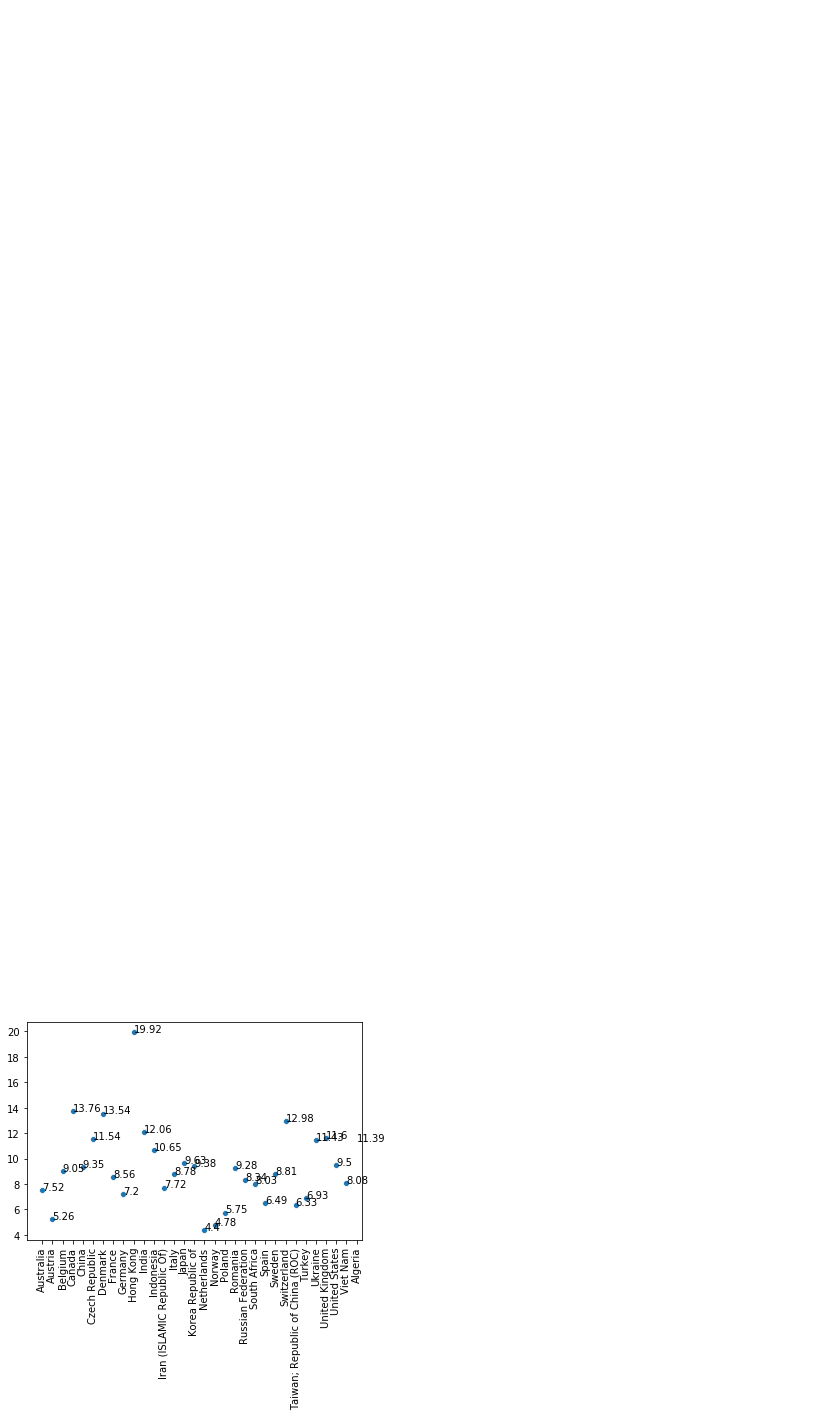

In [15]:
#fig,ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = fraud_pc['fraud'][fraud_pc.obs > 200])
plt.xticks(rotation = 90)
#plt.ylim([0,50000])
for i in fraud_pc.index:
    plt.annotate(round(fraud_pc['fraud'].loc[i],2),xy = (i,fraud_pc['fraud'].loc[i]))

In [16]:
df = df[df.pays.isin(list(fraud_pc[fraud_pc.obs > 200].sort_values(by = 'fraud', ascending = False).index))]

In [17]:
dummies = pd.get_dummies(df[['source','browser','sex','pays']])

In [18]:
dff = pd.concat([df,dummies],axis = 1)

In [19]:
dff = dff.drop(columns = ['source','browser','sex','pays'])

In [20]:
X = dff.drop(columns = ['device_id', 'signup_time','user_id','ip_address','class','purchase_time'])
Y = dff[['class']]

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, stratify = Y, random_state = 42)

In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Regression Logistique

In [23]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()

log.fit(X_train,Y_train)

C:\Users\tashi\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [24]:
print(log.score(X_train,Y_train))
print(log.score(X_test,Y_test))

0.9070839613440908
0.9072541718383671


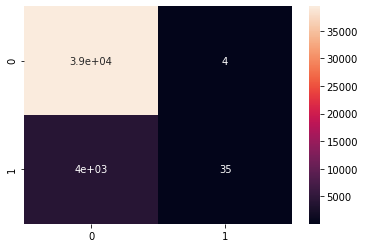

In [25]:
from sklearn import metrics 
y_pred1 = log.predict(X_test)
cm = metrics.confusion_matrix(Y_test, y_pred1)
sns.heatmap(cm, annot=True)

In [26]:
dfpred = pd.DataFrame({'pred':y_pred1,'actual':Y_test['class'].values})
FN = dfpred.pred[(dfpred.actual == 1) & (dfpred.pred == 0)].count()
TP = dfpred.actual[(dfpred.actual == 1) & (dfpred.pred == 1)].count()
FP = dfpred.actual[(dfpred.actual == 0) & (dfpred.pred == 1)].count()
TN = dfpred.actual[(dfpred.actual == 0) & (dfpred.pred == 0)].count()

In [27]:
Accuracy = (TP+TN)/(TP+TN+FP+FN)*100
Recall = TP/(TP+FN)*100
Precision = TP/(TP + FP)*100
print("Le taux d'Accuracy du modèle est de {}% (le pourcentage de nos predictions qui se sont avéré correctes)".format(round(Accuracy,2)))
print("Le taux de Recall du modèle est de {}% (le pourcentage de réelles valeurs 1 que nous avons pu prédire)".format(round(Recall,2)))
print("Le taux de Precision du modèle est de {}% (le pourcentage de prediction 1 qui sont correctes)".format(round(Precision,2)))

Le taux d'Accuracy du modèle est de 90.73% (le pourcentage de nos predictions qui se sont avéré correctes)
Le taux de Recall du modèle est de 0.86% (le pourcentage de réelles valeurs 1 que nous avons pu prédire)
Le taux de Precision du modèle est de 89.74% (le pourcentage de prediction 1 qui sont correctes)


In [28]:
Y['class'].value_counts()/Y['class'].count()*100

0    90.65351
1     9.34649
Name: class, dtype: float64

# SVM

In [29]:
from sklearn import svm

model = svm.SVC(kernel = 'rbf')

model.fit(X_train,Y_train)

C:\Users\tashi\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC()

In [30]:
model.score(X_train,Y_train)

0.9433657436139926

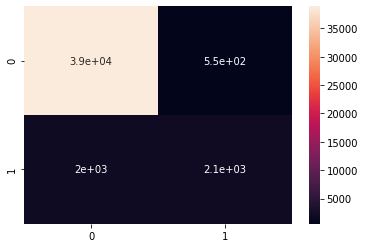

In [31]:
from sklearn import metrics 
y_pred2 = model.predict(X_test)
cm = metrics.confusion_matrix(Y_test, y_pred2)
sns.heatmap(cm, annot=True)

In [32]:
dfpred1 = pd.DataFrame({'pred':y_pred2,'actual':Y_test['class'].values})
FN1 = dfpred1.pred[(dfpred1.actual == 1) & (dfpred1.pred == 0)].count()
TP1 = dfpred1.actual[(dfpred1.actual == 1) & (dfpred1.pred == 1)].count()
FP1 = dfpred1.actual[(dfpred.actual == 0) & (dfpred1.pred == 1)].count()
TN1 = dfpred1.actual[(dfpred.actual == 0) & (dfpred1.pred == 0)].count()

In [33]:
Accuracy = (TP1+TN1)/(TP1+TN1+FP1+FN1)*100
Recall = TP1/(TP1+FN1)*100
Precision = TP1/(TP1 + FP1)*100
print("Le taux d'Accuracy du modèle est de {}% (le pourcentage de nos predictions qui se sont avéré correctes)".format(round(Accuracy,2)))
print("Le taux de Recall du modèle est de {}% (le pourcentage de réelles valeurs 1 que nous avons pu prédire)".format(round(Recall,2)))
print("Le taux de Precision du modèle est de {}% (le pourcentage de prediction 1 qui sont correctes)".format(round(Precision,2)))

Le taux d'Accuracy du modèle est de 94.22% (le pourcentage de nos predictions qui se sont avéré correctes)
Le taux de Recall du modèle est de 51.67% (le pourcentage de réelles valeurs 1 que nous avons pu prédire)
Le taux de Precision du modèle est de 79.31% (le pourcentage de prediction 1 qui sont correctes)


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[1,5,10,50], 'gamma':[0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model,param_grid, n_jobs = -1, verbose = 2)
%time grid.fit(X_train,Y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 46.3min


In [ ]:
print(grid.best_params_)
print(grid.score(X_train,Y_train))
grid.score(X_test,Y_test)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion = 'gini')
dtc.fit(X_train,Y_train)

In [ ]:
import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(dtc,out_file=None, feature_names = X.columns)
graph = graphviz.Source(dot_data)
graph